This is from a project where we were looking for the presence of gravity waves in the upper-level vertical velocity of a mesoscale convective system model in the Weather Research and Forecasting (WRF) Model. Prior to running this code a time series of vertical velocity at 14-km was extracted from the model data. That data is read into the code, then we analyze whether we can find power spectrum associated with waves in this time series are significantly larger than the power spectrum associated with red noise. We know the power spectrum peaks of our time series is significant if they exceed the red noise power spectrum. 

This code was originally designed to run in an Amazon Web Services (AWS) workspace. 

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from datetime import datetime, timedelta
import pandas as pd
from scipy.signal import detrend, welch
import scipy.stats as st
import gc
import netCDF4 as nc4

gc.collect

<function gc.collect(generation=2)>

In [2]:
# Directory and files

DataDirectory = '/mnt/data/directory'

PlotDirectory = '/Local/AWS/Plot/Directory/'

FieldCampaign = 'MC3E'

Parameterization = 'NSSL'

# Set time interval 
dt = 30


In [3]:
# Load data

nc = nc4.Dataset(DataDirectory + FieldCampaign + '/WRF/NSSL/' + FieldCampaign + '_' + 
                 Parameterization + '_CenteredVerticalVelocityCrossSection_30s_AllTimes.nc', 'r')

BaseTime_String = nc.variables['DateTime'].units
DateTime_Seconds = np.array(nc.variables['DateTime'])[:]

Height_Full = np.array(nc.variables['aGeoPotHeight'][:, :])
VerticalVelocity_Full = np.array(nc.variables['aVerticalVelocity'][:, :])

nc.close()


/tmp/ipykernel_191063/889946101.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  DateTime_Seconds = np.array(nc.variables['DateTime'])[:]


In [4]:
# Convert times

BaseTime = datetime.strptime(BaseTime_String[16::], '%y-%m-%d %H:%M:%S.%f')

DateTimes = []
for a in range(0, len(DateTime_Seconds)):
    DateTimes = np.hstack((DateTimes, BaseTime + timedelta(seconds = int(DateTime_Seconds[a]))))
    

In [5]:
# Select level (14 km)

nHeights, nTimes = np.array(np.shape(Height_Full))

VertVelocityFull = np.empty(nTimes, dtype=float)*np.nan

for t in range(0, nTimes):
    if ~np.isnan(Height_Full[1, t]):
        # 4 km
        Index = np.squeeze(np.array(np.nanargmin(np.absolute(Height_Full[:, t] - 14))))
        VertVelocityFull[t] = VerticalVelocity_Full[Index, t]

del Height_Full, VerticalVelocity_Full


In [6]:
# Remove NaNs

GoodIndices = np.squeeze(np.array(np.where(~np.isnan(VertVelocityFull))))
if GoodIndices.size < len(VertVelocityFull):
    DateTimes = DateTimes[GoodIndices]
    
    VertVelocityFull = VertVelocityFull[GoodIndices]
    

/tmp/ipykernel_191063/1618130092.py:36: RuntimeWarning: divide by zero encountered in divide
  xtick_labels = np.round((1 / (time_freqs / (2*np.pi)) / 60), 2)


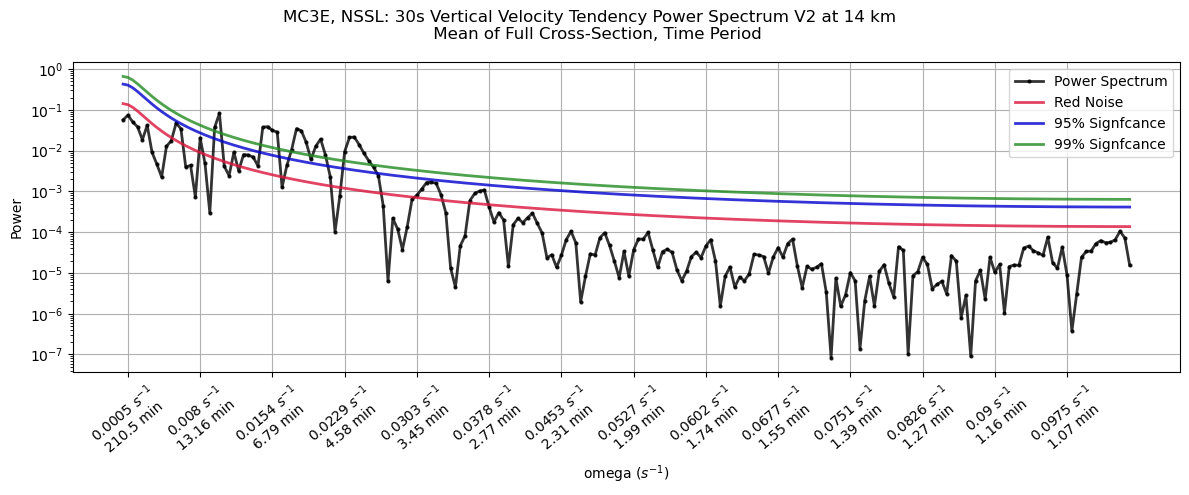

In [7]:
# Conduct spectral analysis of microphysical theta tendency, looping over height levels 
# Using full cross-seciton

AnalysisTitle = 'Full'
DlVertVelocity = np.copy(VertVelocityFull) 

# Detrend data
DlVertVelocity = detrend(DlVertVelocity, axis=-1)

# Calculate frequency
time_size = len(DlVertVelocity)
time_half = int(np.round(time_size / 2))
#time_freqs = np.fft.fftfreq(time_size, dt)[0:time_half]
#time_freqs = welch(DlVertVelocity, fs=1/dt, window='hann', nperseg=time_size)[0]
#time_freqs = np.fft.fftfreq(time_size, dt)[0:time_half]* 2 * np.pi) # wavelengths
time_freqs = welch(DlVertVelocity, fs=1/dt, window='hann', nperseg=time_size)[0] * 2 * np.pi

# Calculate power spectrum
PowerSpec = welch(DlVertVelocity, fs=1/dt, window='hann', nperseg=time_size)[1]

# Normalize the power spectrum
PowerSpec = PowerSpec / np.nansum(PowerSpec)

# Calculate lag-1 autocorrelation (rho)
# Per Google: The relationship is: Te = -dt / log(rho), so rho = exp(-dt / Te)
autocorr_lag1 = pd.Series(DlVertVelocity).autocorr(lag=1)

# Calculate red-noise spectrum given e-folding time scale   
RedSpec = []
for h in np.arange(0, time_half+1):
    RedSpec.append((1-autocorr_lag1**2) / (1-2*autocorr_lag1*np.cos(np.pi*(h)/time_half)+autocorr_lag1**2))

# Plot results
#time_freqs = np.fft.fftfreq(time_size, dt) 
#time_freqs = np.copy(time_freqs[0:time_half]) * 2 * np.pi
xtick_labels = np.round((1 / (time_freqs / (2*np.pi)) / 60), 2) 
x_labels = []
for i in range(len(time_freqs)):
    label = str(np.round(time_freqs[i], 4)) + f' $s^{{-1}}$ \n'+ str(xtick_labels[i])+' min'
    x_labels.append(label)
#print(x_labels)
    
fig = plt.figure(figsize=(12, 5))
plt.suptitle(FieldCampaign + ', ' + Parameterization + 
            ': 30s Vertical Velocity Tendency Power Spectrum V2 at 14 km  \n Mean of Full Cross-Section, Time Period')

# Calculate significance using F-test 
# right now assuming no averaging so DoF = dfn = 2, and dfd = number -2 (https://www.google.com/search?q=scipy+st.f.ppf+how+to+determine+dfd+for+power+spectrum&sca_esv=20541e4f21a9d7f7&rlz=1C5GCCM_en&ei=-_pwaZDeOd7Bp84P9tXW0AY&ved=0ahUKEwjQx9uNg52SAxXe4MkDHfaqFWoQ4dUDCBE&uact=5&oq=scipy+st.f.ppf+how+to+determine+dfd+for+power+spectrum&gs_lp=Egxnd3Mtd2l6LXNlcnAiNnNjaXB5IHN0LmYucHBmIGhvdyB0byBkZXRlcm1pbmUgZGZkIGZvciBwb3dlciBzcGVjdHJ1bTIFECEYoAEyBRAhGKABMgUQIRigATIFECEYoAEyBRAhGKABSMAdUMIHWIUccAJ4AZABAZgB4QGgAecUqgEGMC4xOS4xuAEDyAEA-AEBmAIVoAK1E8ICChAAGLADGNYEGEfCAgUQIRirAsICBxAhGKABGAqYAwCIBgGQBgiSBwQyLjE5oAeafbIHBDAuMTm4B7ETwgcEMTQuN8gHFIAIAA&sclient=gws-wiz-serp)
DoF = 2
Fstat = st.f.ppf(0.95, DoF, time_size-2)
Sig95 = [Fstat*rs for rs in RedSpec]

Fstat = st.f.ppf(0.99, DoF, time_size-2)
Sig99 = [Fstat*rs for rs in RedSpec]

ax = fig.add_subplot(111)
ax.plot(time_freqs[0:time_half], PowerSpec[0:time_half], linewidth=2, marker='o', markersize=2, linestyle='-', 
         color='black', alpha=0.8, label='Power Spectrum')
ax.plot(time_freqs[0:time_half], RedSpec[0:time_half]/np.nansum(RedSpec[0:time_half]), linewidth=2, 
        linestyle='-', color='crimson', alpha=0.8, label='Red Noise')
ax.plot(time_freqs[0:time_half], Sig95[0:time_half]/np.nansum(RedSpec[0:time_half]), linewidth=2, 
        linestyle='-', color='mediumblue', alpha=0.8, label='95% Signfcance')
ax.plot(time_freqs[0:time_half], Sig99[0:time_half]/np.nansum(RedSpec[0:time_half]), linewidth=2, 
        linestyle='-', color='forestgreen', alpha=0.8, label='99% Signfcance')
plt.legend(loc='best')
ax.set_ylabel('Power')
ax.set_yscale('log')
ax.set_xticks(time_freqs[1::15], labels=x_labels[1::15], rotation=40)
#ax.tick_params(axis='x', rotation=20)
#ax.set_xlim(-1e-4, 0.0105)
ax.set_xlabel('omega ($s^{{-1}}$)')
#ax.set_xlabel('frequency')
plt.grid(True)

plt.tight_layout()
plt.savefig(PlotDirectory + FieldCampaign + '_' + Parameterization + 
            '_VertVelocitySpectralAnalysis1D_30s-Sig_14kmFull_V2.png', facecolor='white', transparent=False)
#plt.close()
plt.show()
